In [34]:
import pandas as pd
import os
import librosa
import numpy as np
import scipy
import re


#Data handling
from sklearn.model_selection import train_test_split

#Pickling
from six.moves import cPickle as pickle

# Models 
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#Metrics
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix 

#HTTP
import requests
import json

#
import collections
import itertools
import matplotlib.pyplot as plt
import matplotlib.style as ms
import librosa.display
import IPython.display as ipd
import seaborn
import codecs
ms.use('seaborn-muted')
%matplotlib inline

no_alignment_file = [4764]
wrong_alignment = [3730]

In [2]:
pfief_path = 'Pattern_construction_code/luis_pattern_half/patterns_ignore_5'
# pat_table = pd.read_csv('Pattern_construction_code/luis_pattern_half/patterns_ignore_5',sep='\t')
# pat_table

with codecs.open(pfief_path,'r','utf-8') as content_file:
    content = content_file.read()
len(set(map(lambda x: x.split('\t')[0] ,content.split('\n'))))   

44

# Models

In [3]:
import basic_models

In [4]:
def get_pattern(text):
    text = json.dumps(text)
    url = 'http://192.168.2.101:7878/api/get_patt'
    data = dict(input_tweets = text)
    resp = requests.post(url=url, data=data)
    r = json.loads(resp.text)
    return map(lambda x: x['pattern'],r)
    
def get_deep_emotion(text):
    text = json.dumps(text)
    url = 'http://192.168.2.101:7878/api/get_emo'
    data = dict(input_tweets = text)
    resp = requests.post(url=url, data=data)
    r = json.loads(resp.text)
    return r

def clean_text(text, remove_actions = True):
    punct_str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~«»“…‘”'
    if(remove_actions):
        text = re.sub(r" ?\[[^)]+\]", "", text)
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def get_f1_score(precision,recall):
    return 2 * (precision * recall) / (precision + recall)

def get_patterns_load(data,patterns_df, emotion):
    index = data[data.emotion == emotion ]['index']
    patterns = patterns_df.loc[list(index)]
    load = []
    for pat in patterns.iterrows():
        load = load + list(pat[1].dropna())
    return load


def extract_patterns(data,extract=False):
    if(extract):
        patterns = {}
        for index, row in data.iterrows():
            patterns[row['index']] = set(get_pattern([row['text']])[0].values())
            print('Extracted pattern from '+ row['index'] + ' index:'+ str(index))
            print('Size: ', len(patterns[row['index']]), 'Patterns size', len(patterns))
        try:
            print('Saving Pickle')
            with open('pickles/patterns/pattern.pickle','wb') as f:
                save = {
                    'patterns' : patterns
                }
                pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
                print('Successfully saved in pattern.pickle')
                return patterns
        except Exception as e:
            print('Unable to save data to pickle', e)
            print('Patterns probably not saved.')
            return patterns
    else:
        try:
            with open('pickles/patterns/pattern.pickle','rb') as f:
                save = pickle.load(f)
                patterns = save['patterns']
                del save
                returning = {}
                for key in list(data['index']):
                    returning[key] = patterns[key]
                return returning
        except Exception as e:
            print('Error loading base datasets pickle: ', e)
            
def build_emotions_counter(data,patterns_df):
    emotions_counter ={}
    emotions_list = list(data['emotion'].unique())
    for emotion in emotions_list:
        load = get_patterns_load(data,patterns_df,emotion)
        emotions_counter[emotion] = collections.Counter(load)
    return emotions_counter

def build_frequencyframe(all_patterns,emotions_counter):
    df_patt = {}
    for pattern in all_patterns:
        df_patt[pattern] = {}
        for emotion in emotions_counter:
            df_patt[pattern][emotion] = emotions_counter[emotion][pattern]
    return pd.DataFrame(df_patt).T

def build_pfief(df_patt):
    ief = ((df_patt+1).rdiv(df_patt.sum(axis=1)+1, axis=0)+1).apply(np.log10)
    pf = ((df_patt.sum(axis=0)+1)/(df_patt+1)).apply(np.log10)
    return ief * pf, pf

def balance_data(data):
    min_sample = min(data.groupby('emotion').count()['index'])
    emotions_list = list(data['emotion'].unique())
    samples = []
    for emotion in emotions_list:
        samples.append(data[data.emotion == emotion].sample(n=min_sample))
    result = pd.concat(samples).sample(frac=1)
    return result
        
def two_emotions(data,emotional_mapping,emotion1,emotion2):
    emotion_code = emotional_mapping[emotion1]
    emotion_sample = data[data.emotion_code == emotion_code]
    emotion_code2 = emotional_mapping[emotion2]
    emotion_sample2 = data[data.emotion_code == emotion_code2]
    if(len(emotion_sample2) < len(emotion_sample)):
        emotion_sample = emotion_sample.sample(n=len(emotion_sample2))
    else:
        emotion_sample2 = emotion_sample2.sample(n=len(emotion_sample))
    sample = pd.concat([emotion_sample,emotion_sample2]).sample(frac=1)
    return sample

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]

def remove_empty_patterns(data,patterns):
    empty_patterns = [k for k, v in patterns.items() if len(v) < 1]
    patterns = { k:v for k, v in patterns.items() if len(v) >= 1 }
    data = filter(lambda x: x[1]['index'] not in empty_patterns ,data.iterrows())
    data = pd.DataFrame.from_items(data).T
    return data,patterns


def remove_multiwildcard(patterns):
    for index, patt in patterns.items():
        flt_patt = {p for p in patt if p.split(' ').count('.+') == 1}
        patterns[index] = flt_patt
    return patterns


In [32]:
def load_data(word_count,emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences_votebased.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 4]
    # Clean Transcripts
    
    try:
        data = data.drop(no_alignment_file)
    except Exception as e:
        print('Error at: ',e)
    # Remove rows that have wrong Alignment file
    try:
        data = data.drop(wrong_alignment)
    except Exception as e:
        print('Error at: ',e)
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
    patterns = extract_patterns(data)
    data,patterns = remove_empty_patterns(data,patterns)
    return data,patterns

def build_model(data,patterns):
    transcript_order = list(data['index'])
    patterns_df = pd.DataFrame.from_dict(patterns, orient='index')
    patterns_df = patterns_df.loc[transcript_order]
    emotions_counter = build_emotions_counter(X_train,patterns_df)
    all_patterns = []
    for pat in patterns_df.iterrows():
        all_patterns = all_patterns + list(pat[1].dropna())
        
    df_patt = build_frequencyframe(all_patterns,emotions_counter)
    em_df,pf = build_pfief(df_patt)
    return em_df,pf

def get_frequency_vectors(data,patterns_list):
    patterns = extract_patterns(data)
    transcript_order = list(data['index'])
    frequency_vectors = []
    for index in patterns:
        frequency_vectors.append(np.isin(patterns_list,np.array(list(patterns[index]))))
    vectors = pd.DataFrame(frequency_vectors,columns=patterns_list,index=patterns.keys())
    vectors = vectors.loc[transcript_order]
    vectors = vectors * 1
    return vectors

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def calculate_scores(em_df,vectors):
    em_matrix = em_df.T.as_matrix()
    emotional_scores = []
    for index, vector in vectors.iterrows():
        emotional_scores.append(em_matrix.dot(vector))
    emotions_list = list(em_df.columns)
    scores = pd.DataFrame(emotional_scores,columns=emotions_list,index=list(vectors.index))
    scores['pred_emotion'] = list(map(lambda x: x[1].idxmin(),scores.iterrows()))
    scores['pred_code'] = scores['pred_emotion'].map(emotional_mapping).astype(int)
    return scores

In [80]:
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data,patterns = load_data(3,emotional_mapping)
# data = two_emotions(data,emotional_mapping,'sad','exc')
# Balance Data
# data = balance_data(data)
y = data.emotion_code
# X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

# X_train.groupby('emotion').count()['index'] #  6,453 Total
# X_test.groupby('emotion').count()['index']
try:
    with open('pickles/matrix_basedata.pickle','rb') as f:
        save = pickle.load(f)
        X_train = save['X_train']
        X_test = save['X_test']
        y_train = save['y_train']
        y_test = save['y_test']
        del save
except Exception as e:
    print('Error loading base datasets pickle: ', e)

Error at:  labels [4764] not contained in axis


In [82]:
data.groupby('emotion').count()['index']
data

,index,start_time,end_time,text,wav_path,alignment_path,emotion,valence,arousal,dominance,gender,emotion_code
2,Ses01F_impro01_F002,14.8872,18.0175,is there a problem,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,neu,2.5,2.5,2.5,F,3
5,Ses01F_impro01_F005,27.46,31.49,well what's the problem let me change it,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,neu,2.5,3.5,2,F,3
12,Ses01F_impro01_F012,85.27,88.02,that's out of control,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,ang,2,3.5,3.5,F,0
27,Ses01F_impro01_M011,87.15,94.39,i don't understand why this is so complicated ...,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,ang,2,4,4,M,0
29,Ses01F_impro01_M013,101.84,107.87,yeah do you want to see my supervisor huh yeah...,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,ang,2,4.5,4.5,M,0
30,Ses01F_impro02_F000,7.2688,16.6,did you get the mail so you saw my letter,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,sad,2.5,2,1.5,F,1
31,Ses01F_impro02_F001,19.85,22.78,yeah i know,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,sad,2,1.5,1.5,F,1
32,Ses01F_impro02_F002,26.5659,32.2895,i don't know i put in that request too they di...,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,sad,2,1.5,1.5,F,1
34,Ses01F_impro02_F004,47.34,53.11,there's people that have given more though you...,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,sad,2.5,2,2.5,F,1
37,Ses01F_impro02_F007,72.39,78.57,i'm not okay with it but i don't it's not like...,data/IEMOCAP_full_release/Session1/sentences/w...,data/IEMOCAP_full_release/Session1/sentences/F...,sad,2,3.5,3,F,1


In [83]:
# try:
#     print('Saving Pickle')
#     with open('pickles/matrix_basedata.pickle','wb') as f:
#         save = {
#             'X_train' : X_train,
#             'X_test' : X_test,
#             'y_train' : y_train,
#             'y_test': y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
#         print('Successfully saved in matrix_basedata.pickle')
# except Exception as e:
#     print('Unable to save data to pickle', e)
patterns

{'Ses01F_impro01_F002': {'.+ .+ a',
  '.+ a',
  '.+ a .+',
  '.+ problem',
  '.+ there',
  'a .+',
  'is .+',
  'is .+ a',
  'is there .+',
  'there .+',
  'there a .+'},
 'Ses01F_impro01_F005': {'.+ .+ me',
  '.+ change',
  '.+ it',
  '.+ let',
  '.+ let me',
  '.+ me',
  '.+ me .+',
  '.+ problem',
  '.+ the',
  '.+ the .+',
  'change .+',
  'let .+',
  'let me .+',
  'me .+',
  'me .+ .+',
  'me .+ it',
  'problem .+',
  'the .+',
  'the .+ .+',
  'well .+'},
 'Ses01F_impro01_F012': {'.+ .+ of',
  '.+ of',
  '.+ of .+',
  '.+ out',
  '.+ out .+',
  '.+ out of',
  'of .+',
  'out .+',
  'out of .+'},
 'Ses01F_impro01_M011': {'.+ .+ a',
  '.+ .+ for',
  '.+ .+ i',
  '.+ .+ is',
  '.+ a',
  '.+ a .+',
  '.+ a simple',
  '.+ an',
  '.+ for',
  '.+ for .+',
  '.+ for people',
  '.+ form',
  '.+ get',
  '.+ get .+',
  '.+ here',
  '.+ i',
  '.+ i .+',
  '.+ i just',
  '.+ id',
  '.+ is',
  '.+ is .+',
  '.+ is so',
  '.+ just',
  '.+ just .+',
  '.+ just a',
  '.+ just need',
  '.+ need',

In [88]:
em_df,pf = build_model(X_train,patterns)
patterns_list = np.array(list(em_df.index))

In [85]:
# print(len(em_df))
# em_df.head()
# pf.to_pickle('pickles/patterns/pf_matrix.pickle')
def get_metrics(y_pred,y_true):
    cnf_matrix = confusion_matrix(y_true,y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=EMO_SET, normalize=False,
                          title='Normalized confusion matrix')

    plt.show()
    return cnf_matrix

def load_acoustic_fullmatrices(extraction_type = 'full',extract_fd = False):
    if(extraction_type in ['full','wc','cw']):
        try:
            if(extract_fd):
                fullmfcc_matrix_fd = None
                fullrmse_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix FULLDATA')
                fullzcr_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix FULLDATA')   
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix_fd.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix_fd = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices FULLDATA')
                fullmfcc_matrix_fd.append(fullrmse_matrix_fd)
                fullmfcc_matrix_fd.append(fullzcr_matrix_fd)
                return fullmfcc_matrix_fd
            else:
                fullmfcc_matrix = None
                fullrmse_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix')   
                fullzcr_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix')
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices') 
                fullmfcc_matrix.append(fullrmse_matrix)
                fullmfcc_matrix.append(fullzcr_matrix)
                return fullmfcc_matrix
        except Exception as e:
            print('Error loading matrix: ', e)
    else:
        print('Error')
        return None,None
    
def get_precision_recall(cnf_matrix):
    for i,val in enumerate(EMO_SET):
        diag = cnf_matrix[i][i]
        for_recall = sum(cnf_matrix[i,:])
        for_precision = sum(cnf_matrix[:,i])
        precision = diag/for_precision
        recall = diag/for_recall
        f1 = get_f1_score(precision,recall)
        print('Emo ' ,val, precision,recall,f1)
    
EMO_SET = ['ang','sad','hap','neu']

# Score - Training Data

In [89]:
vectors = get_frequency_vectors(X_train,patterns_list)

In [90]:
scores = calculate_scores(em_df,vectors)
pred_y = list(scores['pred_code'])

In [91]:
# pred_y, y_train
list_y_train = list(y_train)
precision = precision_score(list_y_train,pred_y,average='macro')
recall = recall_score(list_y_train,pred_y,average='macro')
f1 = get_f1_score(precision,recall)
accuracy = accuracy_score(list_y_train,pred_y)
print('Accuracy',accuracy)
print('-')
print('Precision Macro',precision)
print('Recall Macro',recall)
print('F1 Macro',f1)
print('-')
precision = precision_score(list_y_train,pred_y,average='micro')
recall = recall_score(list_y_train,pred_y,average='micro')
f1 = get_f1_score(precision,recall)
print('Precision Micro',precision)
print('Recall Micro',recall)
print('F1 Micro',f1)
print('-')
precision = precision_score(list_y_train,pred_y,average='weighted')
recall = recall_score(list_y_train,pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print('Precision Weighted',precision)
print('Recall Weighted',recall)
print('F1 Weighted',f1)


Accuracy 0.6892453951277481
-
Precision Macro 0.7546802431667767
Recall Macro 0.6276095466225629
F1 Macro 0.6853042375883995
-
Precision Micro 0.6892453951277481
Recall Micro 0.6892453951277481
F1 Micro 0.6892453951277481
-
Precision Weighted 0.7280865493296534
Recall Weighted 0.6892453951277481
F1 Weighted 0.7081337626550592


Confusion matrix, without normalization


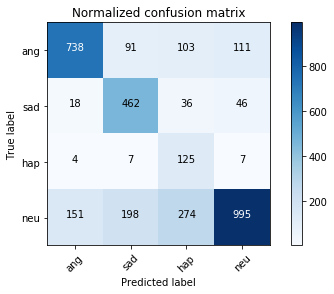

Emo  ang 0.8100987925356751 0.7075743048897412 0.7553735926305016
Emo  sad 0.6094986807387863 0.8220640569395018 0.7
Emo  hap 0.23234200743494424 0.8741258741258742 0.36710719530102787
Emo  neu 0.8584987057808455 0.6149567367119901 0.7166006481814909


In [92]:
cnf_matrix = get_metrics(list_y_train,pred_y)
get_precision_recall(cnf_matrix)

#  Testing

In [93]:
vectors = get_frequency_vectors(X_test,patterns_list)

In [94]:
scores = calculate_scores(em_df,vectors)
pred_y = list(scores['pred_code'])

In [95]:
precision = precision_score(list(y_test),pred_y,average='macro')
recall = recall_score(list(y_test),pred_y,average='macro')
f1 = get_f1_score(precision,recall)
accuracy = accuracy_score(list(y_test),pred_y)
print('Accuracy',accuracy)
print('Precision Macro',precision)
print('Recall Macro',recall)
print('F1 Macro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='micro')
recall = recall_score(list(y_test),pred_y,average='micro')
f1 = get_f1_score(precision,recall)
print('Precision Micro',precision)
print('Recall Micro',recall)
print('F1 Micro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print('Precision Weighted',precision)
print('Recall Weighted',recall)
print('F1 Weighted',f1)

Accuracy 0.5831353919239906
Precision Macro 0.6599539131684076
Recall Macro 0.5276922251210888
F1 Macro 0.5864584368855466
 
Precision Micro 0.5831353919239906
Recall Micro 0.5831353919239906
F1 Micro 0.5831353919239906
 
Precision Weighted 0.633415830621282
Recall Weighted 0.5831353919239906
F1 Weighted 0.6072365582230232


Confusion matrix, without normalization


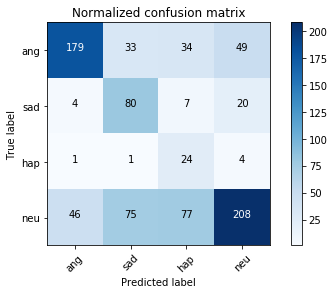

Emo  ang 0.7782608695652173 0.6067796610169491 0.6819047619047619
Emo  sad 0.42328042328042326 0.7207207207207207 0.5333333333333333
Emo  hap 0.16901408450704225 0.8 0.27906976744186046
Emo  neu 0.7402135231316725 0.5123152709359606 0.6055312954876273
Accuracy 0.5831353919239906


In [96]:
cnf_matrix = get_metrics(list(y_test),pred_y)
get_precision_recall(cnf_matrix)
accuracy = accuracy_score(list(y_test),pred_y)
print('Accuracy',accuracy)

# Without multiple wild-card patterns

In [99]:
def remove_multiwildcard(patterns):
    for index, patt in patterns.items():
        flt_patt = {p for p in patt if p.split(' ').count('.+') == 1}
        patterns[index] = flt_patt
    return patterns


patterns = remove_multiwildcard(patterns)
# data = two_emotions(data,emotional_mapping,'sad','exc')
# Balance Data
# data = balance_data(data)
# y = data.emotion_code
# X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3)

# data.groupby('emotion').count()['index'] #  6,453 Total

In [107]:
em_df, pf = build_model(X_train,patterns)
patterns_list = np.array(list(em_df.index))

In [109]:
print(len(em_df))
em_df.head()
# em_df.to_pickle('pickles/patterns/pfief_matrix.pickle')

5853


,ang,hap,neu,sad
.+ a,1.327679,1.879400,1.204144,1.719447
.+ a big,1.543714,4.591001,1.986011,3.402643
.+ a bit,2.101656,1.966405,1.244670,2.064675
.+ a day,1.278035,4.121396,3.061180,2.980944
.+ a dog,2.101656,1.966405,1.244670,2.064675


# Score - Training Data

In [110]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(em_df,vectors)
pred_y = list(scores['pred_code'])

In [111]:
# pred_y, y_train
precision = precision_score(list(y_train),pred_y,average='macro')
recall = recall_score(list(y_train),pred_y,average='macro')
f1 = get_f1_score(precision,recall)
print('Precision Macro',precision)
print('Recall Macro',recall)
print('F1 Macro',f1)
print(' ')
precision = precision_score(list(y_train),pred_y,average='micro')
recall = recall_score(list(y_train),pred_y,average='micro')
f1 = get_f1_score(precision,recall)
print('Precision Micro',precision)
print('Recall Micro',recall)
print('F1 Micro',f1)
print(' ')
precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print('Precision Weighted',precision)
print('Recall Weighted',recall)
print('F1 Weighted',f1)


# Precision Macro 0.7664926811354967
# Recall Macro 0.6423609709732143
# F1 Macro 0.6989583086378197
 
# Precision Micro 0.6947368421052632
# Recall Micro 0.6947368421052632
# F1 Micro 0.6947368421052632
 
# Precision Weighted 0.7386741269995074
# Recall Weighted 0.6947368421052632
# F1 Weighted 0.7160320960247799

Precision Macro 0.7670394021296872
Recall Macro 0.662187429747921
F1 Macro 0.7107673028281568
 
Precision Micro 0.713903743315508
Recall Micro 0.713903743315508
F1 Micro 0.713903743315508
 
Precision Weighted 0.7428851857183716
Recall Weighted 0.713903743315508
F1 Weighted 0.7281061852792923


#  Testing

In [114]:
vectors = get_frequency_vectors(X_test,patterns_list)

In [115]:
scores = calculate_scores(em_df,vectors)
pred_y = list(scores['pred_code'])

In [116]:
precision = precision_score(list(y_test),pred_y,average='macro')
recall = recall_score(list(y_test),pred_y,average='macro')
f1 = get_f1_score(precision,recall)
accuracy = accuracy_score(list(y_test),pred_y)
print('Accuracy',accuracy)
print('Precision Macro',precision)
print('Recall Macro',recall)
print('F1 Macro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='micro')
recall = recall_score(list(y_test),pred_y,average='micro')
f1 = get_f1_score(precision,recall)
print('Precision Micro',precision)
print('Recall Micro',recall)
print('F1 Micro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print('Precision Weighted',precision)
print('Recall Weighted',recall)
print('F1 Weighted',f1)


# Precision Macro 0.6295216882336137
# Recall Macro 0.5249158266314806
# F1 Macro 0.5724794856483989
 
# Precision Micro 0.5874901029295329
# Recall Micro 0.5874901029295329
# F1 Micro 0.5874901029295329
 
# Precision Weighted 0.6153167839850325
# Recall Weighted 0.5874901029295329
# F1 Weighted 0.6010815612885869

Accuracy 0.5843230403800475
Precision Macro 0.6531658776989847
Recall Macro 0.53127159182048
F1 Macro 0.5859464674124917
 
Precision Micro 0.5843230403800475
Recall Micro 0.5843230403800475
F1 Micro 0.5843230403800475
 
Precision Weighted 0.6275370195043622
Recall Weighted 0.5843230403800475
F1 Weighted 0.6051595416434425


# Acoustic Weights

In [117]:
# try:
#     with open('pickles/patterns/scaledmfcc20_pattern_features4emo.pickle','rb') as f:
#         save = pickle.load(f)
#         full_feature_table = save['full_feature_table']
#         wc_feature_table = save['wc_feature_table']
#         cw_feature_table = save['cw_feature_table']
#         del save
# except Exception as e:
#     print('Error loading pattern features pickle: ', e)
    

##############################MATRIX OPERATIONS###############################################
def calculate_final_matrix(em_df,matrix):
    final = []
    for val in em_df.iterrows():
        final.append(val[1] * matrix.loc[val[0]])
    return pd.DataFrame(final)

def calculate_final_matrix_mul(em_df,matrix):
    final = []
    for val in em_df.iterrows():
        final.append(val[1] + (val[1] * matrix.loc[val[0]]))
    return pd.DataFrame(final)

def calculate_final_matrix_sum(em_df,matrix):
    final = []
    for val in em_df.iterrows():
        final.append(val[1] + matrix.loc[val[0]])
    return pd.DataFrame(final)

##############################MULTI MATRIX OPERATIONS###############################################
def calculate_final_multimatrix(em_df,multimatrix):
    final = []
    mmatrix_size = len(multimatrix)
    for val in em_df.iterrows():
        temp_val = val[1]
        for i in range(mmatrix_size):
            temp_val = temp_val * multimatrix[i].loc[val[0]]
        final.append(temp_val)
    return pd.DataFrame(final)

def calculate_final_multimatrix_mul(em_df,multimatrix):
    final = []
    mmatrix_size = len(multimatrix)
    for val in em_df.iterrows():
        temp_val = val[1]
        for i in range(mmatrix_size):
            temp_val = temp_val ( 1 + multimatrix[i].loc[val[0]])
        final.append(temp_val)
    return pd.DataFrame(final)

def calculate_final_multimatrix_sum(em_df,multimatrix):
    final = []
    mmatrix_size = len(multimatrix)
    for val in em_df.iterrows():
        temp_val = val[1]
        for i in range(mmatrix_size):
            temp_val = temp_val + multimatrix[i].loc[val[0]]
        final.append(temp_val)
    return pd.DataFrame(final)


################################### MATRIX BUILD OPERATIONS ######################################################

def build_acumatrix(data,feature_table,saveToPickle = False, savePath = ''):
    matrix = {}
    emotions_list = list(data['emotion'].unique())
    for index, row in data.iterrows():
        emo = row.emotion
        key = row['index']
        patts = feature_table[key].keys()
        for patt in patts:
            tpatt = patt.split('_')[1]
            if(tpatt not in matrix):
                matrix[tpatt] = {}
            if(emo not in matrix[tpatt]):
                matrix[tpatt][emo] = []
            matrix[tpatt][emo].append(feature_table[key][patt])
    for val in matrix:
        for emo in matrix[val].keys():
            matrix[val][emo] = np.mean(matrix[val][emo])
    matrix = pd.DataFrame(matrix).T
    if(saveToPickle and savePath != ''):
        matrix.to_pickle(savePath)
    return matrix

def build_multiacumatrix(data,feature_table,saveToPickle = False, savePath = '',size = 20):
    multimatrix = []
    count = 0
    for i in range(size):
        multimatrix.append(dict())
    emotions_list = list(data['emotion'].unique())
    for index, row in data.iterrows():
        emo = row.emotion
        key = row['index']
        patts = feature_table[key].keys()
        for patt in patts:
            tpatt = patt.split('_')[1]
            if(tpatt not in multimatrix[0]):
                for matrix in multimatrix:
                    matrix[tpatt] = {}
                    for emotion in emotions_list:
                        matrix[tpatt][emotion] = []
            for i in range(size):
                sub_feature = feature_table[key][patt][i]
                multimatrix[i][tpatt][emo].append(sub_feature)
    for i in range(size):
        for val in multimatrix[i]:
            for emo in multimatrix[i][val].keys():
                if(len(multimatrix[i][val][emo]) > 0):
                    multimatrix[i][val][emo] = np.mean(multimatrix[i][val][emo])
                else:
                    multimatrix[i][val][emo] = np.nan
        multimatrix[i] = pd.DataFrame(multimatrix[i]).T
    if(saveToPickle and savePath != ''):
        try:
            print('Saving Pickle')
            with open(savePath,'wb') as f:
                save = {
                    'multimatrix' : multimatrix
                }
                pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
                print('Successfully saved matrix to '+savePath)
        except Exception as e:
            print('Unable to save data to pickle', e)
            print('Patterns probably not saved.')
    return multimatrix

############################## LOAD MATRICES ###############################################

def get_acumatrix(filePath):
    try:
        matrix = pd.read_pickle(filePath)
        return matrix
    except Exception as e:
        print('Error loading matrix: ', e)

def get_multiacumatrix(filePath):
    try:
        with open(filePath,'rb') as f:
            save = pickle.load(f)
            multimatrix = save['multimatrix']
            del save
            return multimatrix
    except Exception as e:
        print('Error loading matrix: ', e)

In [377]:
# full_matrix = build_acumatrix(X_train,full_feature_table,saveToPickle=True,savePath = 'pickles/patterns/full_rmse_matrix_fd.pickle')
# full_matrix = full_matrix.fillna(np.max(full_matrix))

# wc_matrix = build_acumatrix(X_train,wc_feature_table,saveToPickle=True,savePath = 'pickles/patterns/wc_rmse_matrix_fd.pickle')
# wc_matrix = wc_matrix.fillna(np.max(wc_matrix))

# cw_matrix = build_acumatrix(X_train,cw_feature_table,saveToPickle=True,savePath = 'pickles/patterns/cw_rmse_matrix_fd.pickle')
# cw_matrix = cw_matrix.fillna(np.max(cw_matrix))

# #FOR MFCC 20 
# MATRIX_SIZE = 20
# savePath = 'pickles/patterns/full_mfcc20_matrix_fd.pickle'
# # full_matrices = get_multiacumatrix(savePath)
# full_matrices = build_multiacumatrix(data,full_feature_table,size = MATRIX_SIZE,saveToPickle=True,savePath=savePath)
# for i in range(MATRIX_SIZE):
#     full_matrices[i] = full_matrices[i].fillna(np.max(full_matrices[i]))
    
# savePath = 'pickles/patterns/wc_mfcc20_matrix_fd.pickle'
# # wc_matrices = get_multiacumatrix(savePath)
# wc_matrices = build_multiacumatrix(data,wc_feature_table,size = MATRIX_SIZE,saveToPickle=True,savePath=savePath)
# for i in range(MATRIX_SIZE):
#     wc_matrices[i] = wc_matrices[i].fillna(np.max(wc_matrices[i]))

# savePath = 'pickles/patterns/cw_mfcc20_matrix_fd.pickle'
# # cw_matrices = get_multiacumatrix(savePath)
# cw_matrices = build_multiacumatrix(data,cw_feature_table,size = MATRIX_SIZE,saveToPickle=True,savePath=savePath)
# for i in range(MATRIX_SIZE):
#     cw_matrices[i] = cw_matrices[i].fillna(np.max(cw_matrices[i]))


Saving Pickle
Successfully saved matrix to pickles/patterns/full_mfcc20_matrix_fd.pickle
Saving Pickle
Successfully saved matrix to pickles/patterns/wc_mfcc20_matrix_fd.pickle
Saving Pickle
Successfully saved matrix to pickles/patterns/cw_mfcc20_matrix_fd.pickle


In [118]:
# full_matrices = load_acoustic_fullmatrices(extraction_type='full')
# wc_matrices = load_acoustic_fullmatrices(extraction_type='wc')
# cw_matrices = load_acoustic_fullmatrices(extraction_type='cw')
##################### FULLDATA ACOUSTIC MATRICES ###################################
full_matrices = load_acoustic_fullmatrices(extraction_type='full',extract_fd = True)
wc_matrices = load_acoustic_fullmatrices(extraction_type='wc',extract_fd = True)
cw_matrices = load_acoustic_fullmatrices(extraction_type='cw',extract_fd = True)
########################################################################################
RMSE_INDEX = 20
ZCR_INDEX = 21
###########################################################################################
for i,am in enumerate(full_matrices):
    full_matrices[i] = full_matrices[i].fillna(np.max(full_matrices[i]))
for i,am in enumerate(wc_matrices):
    wc_matrices[i] = wc_matrices[i].fillna(np.max(wc_matrices[i]))
for i,am in enumerate(cw_matrices):
    cw_matrices[i] = cw_matrices[i].fillna(np.max(cw_matrices[i]))

em_df = pd.read_pickle('pickles/patterns/pfief_matrix.pickle')

patterns_list = np.array(list(em_df.index))
print(len(em_df),len(full_matrices),len(wc_matrices),len(cw_matrices))

Successfully loaded full RMSE Matrix FULLDATA
Successfully loaded full ZCR Matrix FULLDATA
Successfully loaded full MFCC Matrices FULLDATA
Successfully loaded wc RMSE Matrix FULLDATA
Successfully loaded wc ZCR Matrix FULLDATA
Successfully loaded wc MFCC Matrices FULLDATA
Successfully loaded cw RMSE Matrix FULLDATA
Successfully loaded cw ZCR Matrix FULLDATA
Successfully loaded cw MFCC Matrices FULLDATA
5853 22 22 22


In [68]:
full_matrix = full_matrices[RMSE_INDEX]
wc_matrix = wc_matrices[RMSE_INDEX]
cw_matrix = cw_matrices[RMSE_INDEX]


In [119]:
summatrix = calculate_final_matrix_sum(em_df,full_matrix)
mulmatrix = calculate_final_matrix(em_df,full_matrix)
mul2matrix = calculate_final_matrix_mul(em_df,full_matrix)
em_df.head()

########### FOR MFCC 20 ################
# summatrix = calculate_final_multimatrix_sum(em_df,full_matrices)
# mulmatrix = calculate_final_multimatrix(em_df,full_matrices)
# mul2matrix = calculate_final_multimatrix_mul(em_df,full_matrices)
# em_df.head()

,ang,hap,neu,sad
.+ a,1.327679,1.879400,1.204144,1.719447
.+ a big,1.543714,4.591001,1.986011,3.402643
.+ a bit,2.101656,1.966405,1.244670,2.064675
.+ a day,1.278035,4.121396,3.061180,2.980944
.+ a dog,2.101656,1.966405,1.244670,2.064675


In [120]:
mulmatrix.head()

,ang,hap,neu,sad
.+ a,0.120278,0.062782,0.032966,0.033268
.+ a big,0.091509,1.777949,0.071025,0.065940
.+ a bit,0.021994,0.761526,0.032335,0.358585
.+ a day,0.123201,1.596085,0.026179,0.216500
.+ a dog,1.480224,0.761526,0.035370,0.358585


In [71]:
# print(summatrix.shape,mulmatrix.shape,em_df.shape,full_matrix.shape,cw_matrix.shape,wc_matrix.shape)

# Full Pattern Feature

# Train

In [72]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(mulmatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

In [74]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(summatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.7559411024438848
0.7228163992869875
0.739007748196659


In [75]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(mul2matrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.7628035055352633
0.7248960190136661
0.743366809396322


## Testing

In [76]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(mulmatrix,vectors)
pred_y = list(scores['pred_code'])

In [121]:
# precision = precision_score(list(y_test),pred_y,average='weighted')
# recall = recall_score(list(y_test),pred_y,average='weighted')
# f1 = get_f1_score(precision,recall)
# print(precision)
# print(recall)
# print(f1)
accuracy = accuracy_score(list(y_test),pred_y)
print('Accuracy', accuracy)
####################
precision = precision_score(list(y_test),pred_y,average='macro')
recall = recall_score(list(y_test),pred_y,average='macro')
f1 = get_f1_score(precision,recall)
print('Precision Macro',precision)
print('Recall Macro',recall)
print('F1 Macro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='micro')
recall = recall_score(list(y_test),pred_y,average='micro')
f1 = get_f1_score(precision,recall)
print('Precision Micro',precision)
print('Recall Micro',recall)
print('F1 Micro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print('Precision Weighted',precision)
print('Recall Weighted',recall)
print('F1 Weighted',f1)

Accuracy 0.5843230403800475
Accuracy 0.5843230403800475
Precision Macro 0.6531658776989847
Recall Macro 0.53127159182048
F1 Macro 0.5859464674124917
 
Precision Micro 0.5843230403800475
Recall Micro 0.5843230403800475
F1 Micro 0.5843230403800475
 
Precision Weighted 0.6275370195043622
Recall Weighted 0.5843230403800475
F1 Weighted 0.6051595416434425


Confusion matrix, without normalization


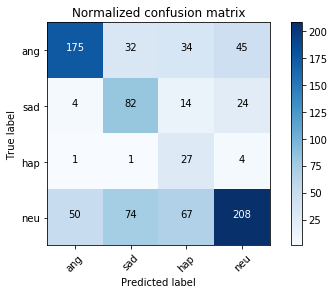

Emo  ang 0.7608695652173914 0.6118881118881119 0.6782945736434108
Emo  sad 0.43386243386243384 0.6612903225806451 0.5239616613418531
Emo  hap 0.19014084507042253 0.8181818181818182 0.30857142857142855
Emo  neu 0.7402135231316725 0.5213032581453634 0.611764705882353


In [123]:
cnf_matrix = get_metrics(list(y_test),pred_y)
get_precision_recall(cnf_matrix)

Accuracy 0.6104513064133017
Precision Macro 0.6836481257722961
Recall Macro 0.5565272694153125
F1 Macro 0.613572606186718
 
Precision Micro 0.6104513064133017
Recall Micro 0.6104513064133017
F1 Micro 0.6104513064133017
 
Precision Weighted 0.659767071766235
Recall Weighted 0.6104513064133017
F1 Weighted 0.6341518557862497
Confusion matrix, without normalization


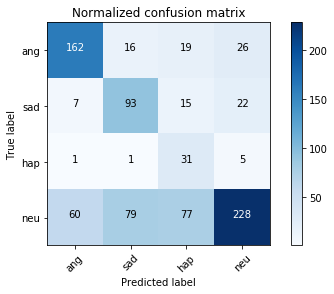

Emo  ang 0.7043478260869566 0.726457399103139 0.7152317880794702
Emo  sad 0.49206349206349204 0.6788321167883211 0.5705521472392637
Emo  hap 0.21830985915492956 0.8157894736842105 0.34444444444444444
Emo  neu 0.8113879003558719 0.5135135135135135 0.6289655172413793


In [126]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(mul2matrix,vectors)
pred_y = list(scores['pred_code'])

accuracy = accuracy_score(list(y_test),pred_y)
print('Accuracy', accuracy)
####################
precision = precision_score(list(y_test),pred_y,average='macro')
recall = recall_score(list(y_test),pred_y,average='macro')
f1 = get_f1_score(precision,recall)
print('Precision Macro',precision)
print('Recall Macro',recall)
print('F1 Macro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='micro')
recall = recall_score(list(y_test),pred_y,average='micro')
f1 = get_f1_score(precision,recall)
print('Precision Micro',precision)
print('Recall Micro',recall)
print('F1 Micro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print('Precision Weighted',precision)
print('Recall Weighted',recall)
print('F1 Weighted',f1)
cnf_matrix = get_metrics(list(y_test),pred_y)
get_precision_recall(cnf_matrix)

Accuracy 0.5985748218527316
Precision Macro 0.6727220878449357
Recall Macro 0.543838847262289
F1 Macro 0.6014534812417346
 
Precision Micro 0.5985748218527316
Recall Micro 0.5985748218527316
F1 Micro 0.5985748218527316
 
Precision Weighted 0.6469954444251524
Recall Weighted 0.5985748218527316
F1 Weighted 0.6218439751995721
Confusion matrix, without normalization


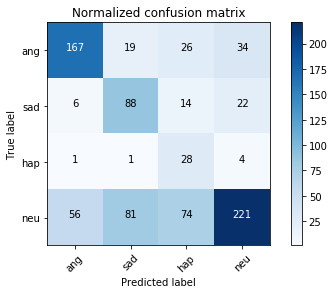

Emo  ang 0.7260869565217392 0.6788617886178862 0.7016806722689076
Emo  sad 0.4656084656084656 0.676923076923077 0.5517241379310345
Emo  hap 0.19718309859154928 0.8235294117647058 0.3181818181818182
Emo  neu 0.7864768683274022 0.5115740740740741 0.6199158485273492


In [127]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(summatrix,vectors)
pred_y = list(scores['pred_code'])

accuracy = accuracy_score(list(y_test),pred_y)
print('Accuracy', accuracy)
####################
precision = precision_score(list(y_test),pred_y,average='macro')
recall = recall_score(list(y_test),pred_y,average='macro')
f1 = get_f1_score(precision,recall)
print('Precision Macro',precision)
print('Recall Macro',recall)
print('F1 Macro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='micro')
recall = recall_score(list(y_test),pred_y,average='micro')
f1 = get_f1_score(precision,recall)
print('Precision Micro',precision)
print('Recall Micro',recall)
print('F1 Micro',f1)
print(' ')
precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print('Precision Weighted',precision)
print('Recall Weighted',recall)
print('F1 Weighted',f1)
cnf_matrix = get_metrics(list(y_test),pred_y)
get_precision_recall(cnf_matrix)

# WildCard Weights

## Train

In [313]:
summatrix = calculate_final_matrix_sum(em_df,wc_matrix)
mulmatrix = calculate_final_matrix(em_df,wc_matrix)
mul2matrix = calculate_final_matrix_mul(em_df,wc_matrix)
em_df.head()

# mulmatrix = em_df + matrix

######## FOR MFCC 20 #########
# summatrix = calculate_final_multimatrix_sum(em_df,wc_matrices)
# mulmatrix = calculate_final_multimatrix(em_df,wc_matrices)
# mul2matrix = calculate_final_multimatrix_mul(em_df,wc_matrices)
# em_df.head()

,ang,hap,neu,sad
.+ a,1.335632,1.773339,1.233435,1.653975
.+ a big,1.514692,3.875035,2.202922,2.782855
.+ a bit,1.218580,1.937517,2.090332,2.043222
.+ a day,1.387807,3.667312,2.665174,2.600678
.+ a dog,2.075031,1.937517,1.228233,2.043222


In [314]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(summatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.7415662562860448
0.700169779286927
0.7202737105535195


In [315]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(mulmatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.3466977506030511
0.31171477079796267
0.3282768973938682


In [316]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(mul2matrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.7205521557316455
0.6706281833616299
0.694694382369676


## Test

In [317]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(summatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.6146234821838491
0.5748218527315915
0.594056739541341


In [318]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(mulmatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.3049228908295152
0.3008709422011085
0.3028833654631287


In [319]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(mul2matrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.6072264621141198
0.564528899445764
0.5850997531008266


# ContentWord Weights

In [320]:
summatrix = calculate_final_matrix_sum(em_df,cw_matrix)
mulmatrix = calculate_final_matrix(em_df,cw_matrix)
mul2matrix = calculate_final_matrix_mul(em_df,cw_matrix)
em_df.head()

############ FOR MFCC 20 ############
# summatrix = calculate_final_multimatrix_sum(em_df,cw_matrices)
# mulmatrix = calculate_final_multimatrix(em_df,cw_matrices)
# mul2matrix = calculate_final_multimatrix_mul(em_df,cw_matrices)


,ang,hap,neu,sad
.+ a,1.335632,1.773339,1.233435,1.653975
.+ a big,1.514692,3.875035,2.202922,2.782855
.+ a bit,1.218580,1.937517,2.090332,2.043222
.+ a day,1.387807,3.667312,2.665174,2.600678
.+ a dog,2.075031,1.937517,1.228233,2.043222


## Train

In [321]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(summatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.7420164285845253
0.7011884550084889
0.7210249342488


In [322]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(mulmatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.3257189908340611
0.31069609507640067
0.3180302314788517


In [323]:
vectors = get_frequency_vectors(X_train,patterns_list)
scores = calculate_scores(mul2matrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_train),pred_y,average='weighted')
recall = recall_score(list(y_train),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.7229990440256301
0.6730050933786078
0.6971068725367464


## Test

In [324]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(summatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.6152201537413479
0.5756136183689627
0.5947582392813809


In [325]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(mulmatrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.27840602671199105
0.2921615201900237
0.285117961706323


In [326]:
vectors = get_frequency_vectors(X_test,patterns_list)
scores = calculate_scores(mul2matrix,vectors)
pred_y = list(scores['pred_code'])

precision = precision_score(list(y_test),pred_y,average='weighted')
recall = recall_score(list(y_test),pred_y,average='weighted')
f1 = get_f1_score(precision,recall)
print(precision)
print(recall)
print(f1)

0.5972116221812408
0.5613618368962787
0.5787320788625733


In [18]:
import os
from six.moves import cPickle as pickle
import numpy as np
import pandas as pd
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

def get_scores_from_multiple(history_folder):
    V_folder = os.listdir(history_folder)
    values = []
    for pkl in V_folder:
        history = pickle.load(open(history_folder+pkl, 'rb'))
        values.append([pkl,get_avg(history,'acc'),get_avg(history,'val_acc'),get_avg(history,'loss'),get_avg(history,'val_loss')])
    # histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))
    scores = pd.DataFrame(data=values,columns=['Model','Train Acc','Valid Acc','Train Loss','Valid Loss'])
    return scores

In [24]:
get_scores_from_multiple('history/mfcc20_zcr/').sort_values(by='Valid Acc', ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
2,_FS1_1_1_FM_150_data_full.pkl,0.871881,0.828385,0.865006,0.933542
1,_FS1_1_1_FM_150_data_wc.pkl,0.874629,0.827494,0.861868,0.931364
0,_FS1_1_1_FM_150_data_cw.pkl,0.869875,0.821853,0.879001,0.952862


In [18]:
get_scores_from_multiple('history/rmse_zcr/').sort_values(by='Valid Acc', ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
12,_FS1_1_1_FM_150_data_full.pkl,0.851679,0.813638,0.897900,0.967120
2,_FS1_1_1_FM_150_data_cw.pkl,0.851679,0.812451,0.900729,0.971308
5,_FS1_3_5_FM_150_data_cw.pkl,0.844202,0.812154,0.804264,0.864101
16,_FS5_5_5_FM_150_data_wc.pkl,0.839399,0.811263,0.719572,0.776293
13,_FS5_5_5_FM_150_data_cw.pkl,0.841107,0.811164,0.717838,0.774117
17,_FS5_5_5_FM_150_data_full.pkl,0.841949,0.811164,0.716998,0.773772
8,_FS1_3_5_FM_150_data_wc.pkl,0.848014,0.811065,0.791513,0.859771
14,_FS1_3_5_FM_150_data_full.pkl,0.846529,0.810768,0.792310,0.856277
9,_FS1_2_3_FM_150_data_cw.pkl,0.843063,0.810570,0.829279,0.890647
0,_FS1_2_3_FM_150_data_full.pkl,0.843434,0.810471,0.831618,0.892245


In [19]:
get_scores_from_multiple('history/zcr_mfcc1/').sort_values(by='Valid Acc', ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
7,_FS5_5_5_FM_150_data_wc.pkl,0.842320,0.814430,0.720075,0.779555
8,_FS5_5_5_FM_150_data_full.pkl,0.839795,0.812648,0.723791,0.778203
6,_FS1_3_5_FM_150_data_full.pkl,0.842395,0.811461,0.802942,0.863051
3,_FS1_3_5_FM_150_data_wc.pkl,0.844326,0.811164,0.811899,0.874647
4,_FS1_1_1_FM_150_data_full.pkl,0.848039,0.810867,0.927611,0.998446
5,_FS5_5_5_FM_150_data_cw.pkl,0.840761,0.810867,0.725527,0.779051
0,_FS1_1_1_FM_150_data_cw.pkl,0.849970,0.810867,0.899584,0.968672
1,_FS1_3_5_FM_150_data_cw.pkl,0.848113,0.808492,0.800778,0.866037
2,_FS1_1_1_FM_150_data_wc.pkl,0.844623,0.807007,0.889987,0.959914


In [20]:
get_scores_from_multiple('history/cce_mfcc1/').sort_values(by='Valid Acc', ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
2,_FS1_1_1_FM_150_data_cw.pkl,0.684393,0.588678,1.400685,1.592019
12,_FS1_1_1_FM_150_data_full.pkl,0.688552,0.587886,1.410630,1.600070
7,_FS1_1_1_FM_150_data_wc.pkl,0.689741,0.586698,1.402474,1.600592
13,_FS5_5_5_FM_150_data_cw.pkl,0.663102,0.585907,1.262750,1.408356
16,_FS5_5_5_FM_150_data_wc.pkl,0.660032,0.585511,1.260003,1.406099
6,_FS2_3_5_FM_150_data_wc.pkl,0.674787,0.584323,1.317390,1.469504
17,_FS5_5_5_FM_150_data_full.pkl,0.672906,0.583927,1.253158,1.404442
0,_FS1_2_3_FM_150_data_full.pkl,0.680828,0.583531,1.363385,1.532598
11,_FS1_2_2_FM_150_data_cw.pkl,0.683007,0.583135,1.381595,1.552113
8,_FS1_3_5_FM_150_data_wc.pkl,0.673401,0.583135,1.336944,1.498612


In [17]:
get_scores_from_multiple('history/mfcc20/').sort_values(by='Valid Acc', ascending=False)

NameError: name 'get_scores_from_multiple' is not defined